In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import query_weather_data
import forecastData

# Testing simple machine learning bias correction site forecast

1. Get Obs

In this method we want to use a single site (we are not using surrounding sites)

In [8]:
siteObs = query_weather_data.retrieve_data('../../weather_observations.db', 'Karratha')
siteObs.index = pd.to_datetime(siteObs.date)
siteObs = siteObs.sort_index()

Generated Query: SELECT * FROM observations WHERE 1=1 AND name = 'Karratha' AND date BETWEEN '20241002212301' AND '20241012212301'


In [10]:
siteObs.head(1)

,id,date,station_id,name,latitude,longitude,apparent_t,gust_kmh,gust_kt,air_temp,dewpt,press,press_msl,rel_hum,wind_direction_deg,wind_speed_kmh
date,,,,,,,,,,,,,,,,
2024-10-02 21:30:00,3585974,20241002213000,95307,Karratha,-20.7097,116.7742,19.0,20.0,11.0,20.9,14.1,1013.9,1013.9,65.0,235.0,17.0


2. Get the latest forecast and historic forecasts

In [29]:
forecast = forecastData.getData([siteObs.iloc[0]['latitude']], [siteObs.iloc[0]['longitude']], [siteObs.iloc[0]['name']], pastDays = 50)

<Axes: xlabel='time'>

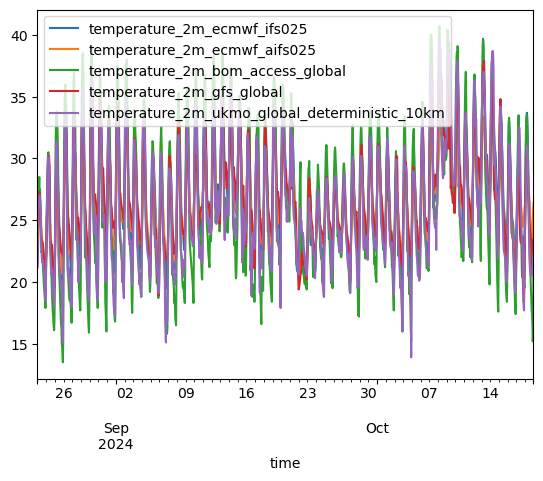

In [30]:
forecast[[col for col in forecast.columns if 'temperature' in col]].plot()

## Check data for overlaps

<Axes: xlabel='date'>

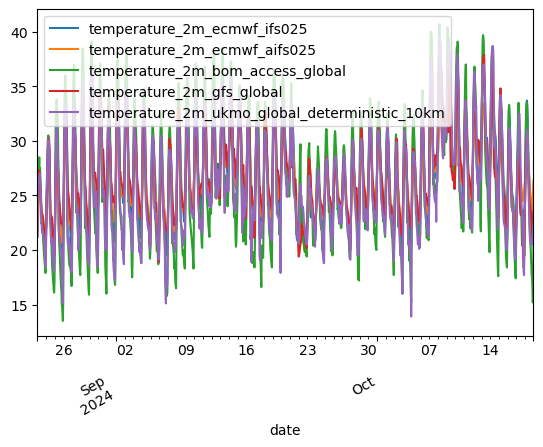

In [31]:
forecast[[col for col in forecast.columns if 'temperature' in col]].plot()
siteObs.air_temp.plot(color = 'black')

<Axes: xlabel='date'>

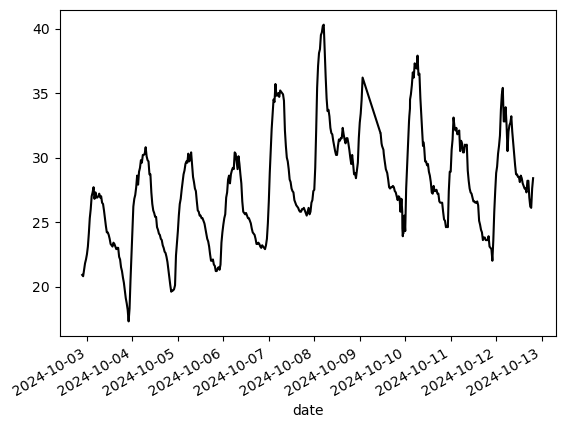

In [91]:
siteObs.air_temp.plot(color = 'black')
forecast['temperature_2m_bom_access_global'].plot()

3. Join the forecast and obs data for training

In [17]:
df = forecast.join(siteObs[['apparent_t', 'gust_kmh', 'gust_kt', 'air_temp', 'dewpt', 'press',
       'press_msl', 'rel_hum', 'wind_direction_deg', 'wind_speed_kmh']], how='inner', rsuffix='_obs')

In [54]:
df = df[~df.index.duplicated(keep='first')]

In [78]:
import numpy as np
import pandas as pd

# Function to create supervised data with flexibility to select features and label
def create_supervised_data(df, feature_columns, label_column, input_seq_length, output_seq_length):
    X = []
    y = []

    for i in range(len(df) - input_seq_length - output_seq_length):
        # Input: the past 'input_seq_length' hours as features, selecting the specified columns
        X_seq = df[feature_columns].iloc[i:i+input_seq_length].values.flatten()  # Flatten into a 1D array
        # Output: the label for the first step of 'output_seq_length', selecting the specified label column
        y_seq = df[label_column].iloc[i+input_seq_length:i+input_seq_length+output_seq_length].values[0]
        X.append(X_seq)
        y.append(y_seq)

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    return X, y

# Define feature columns and label column
feature_columns = ['temperature_2m_ecmwf_ifs025', 'relative_humidity_2m_ecmwf_ifs025',
       'cloud_cover_ecmwf_ifs025', 'wind_speed_10m_ecmwf_ifs025',
       'wind_direction_10m_ecmwf_ifs025', 'temperature_2m_ecmwf_aifs025',
       'relative_humidity_2m_ecmwf_aifs025', 'cloud_cover_ecmwf_aifs025',
       'wind_speed_10m_ecmwf_aifs025', 'wind_direction_10m_ecmwf_aifs025',
       'temperature_2m_bom_access_global',
       'relative_humidity_2m_bom_access_global',
       'cloud_cover_bom_access_global', 'wind_speed_10m_bom_access_global',
       'wind_direction_10m_bom_access_global', 'temperature_2m_gfs_global',
       'relative_humidity_2m_gfs_global', 'cloud_cover_gfs_global',
       'wind_speed_10m_gfs_global', 'wind_direction_10m_gfs_global',
       'temperature_2m_ukmo_global_deterministic_10km',
       'relative_humidity_2m_ukmo_global_deterministic_10km',
       'cloud_cover_ukmo_global_deterministic_10km',
       'wind_speed_10m_ukmo_global_deterministic_10km',
       'wind_direction_10m_ukmo_global_deterministic_10km']
label_column = 'air_temp'  # This is the target we're predicting

# Parameters for sequence generation
input_seq_length = 48  # Look-back period (e.g., 24 hours)
output_seq_length = 12  # Predict 48 hours into the future

# Create supervised data using specified feature and label columns
X, y = create_supervised_data(df, feature_columns, label_column, input_seq_length, output_seq_length)

print(f"Feature shape (X): {X.shape}")  # Example: (samples, input_seq_length * len(feature_columns))
print(f"Target shape (y): {y.shape}")  # Example: (samples,)


Feature shape (X): (156, 1200)
Target shape (y): (156,)


In [66]:
featureCols = ['temperature_2m_ecmwf_ifs025', 'relative_humidity_2m_ecmwf_ifs025',
       'cloud_cover_ecmwf_ifs025', 'wind_speed_10m_ecmwf_ifs025',
       'wind_direction_10m_ecmwf_ifs025', 'temperature_2m_ecmwf_aifs025',
       'relative_humidity_2m_ecmwf_aifs025', 'cloud_cover_ecmwf_aifs025',
       'wind_speed_10m_ecmwf_aifs025', 'wind_direction_10m_ecmwf_aifs025',
       'temperature_2m_bom_access_global',
       'relative_humidity_2m_bom_access_global',
       'cloud_cover_bom_access_global', 'wind_speed_10m_bom_access_global',
       'wind_direction_10m_bom_access_global', 'temperature_2m_gfs_global',
       'relative_humidity_2m_gfs_global', 'cloud_cover_gfs_global',
       'wind_speed_10m_gfs_global', 'wind_direction_10m_gfs_global',
       'temperature_2m_ukmo_global_deterministic_10km',
       'relative_humidity_2m_ukmo_global_deterministic_10km',
       'cloud_cover_ukmo_global_deterministic_10km',
       'wind_speed_10m_ukmo_global_deterministic_10km',
       'wind_direction_10m_ukmo_global_deterministic_10km']

In [67]:
targetParam = 'air_temp'

4. Train Model

In [80]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [81]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up parameters (you can tune these)
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'
}

# Train the model
bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'test')])

# Predictions on test set
y_pred = bst.predict(dtest)

# Evaluate performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

[0]	test-rmse:25.25475
[1]	test-rmse:22.77497
[2]	test-rmse:20.55913
[3]	test-rmse:18.52012
[4]	test-rmse:16.68925
[5]	test-rmse:15.03128
[6]	test-rmse:13.54419
[7]	test-rmse:12.22967
[8]	test-rmse:11.05083
[9]	test-rmse:9.95777
[10]	test-rmse:9.03706
[11]	test-rmse:8.16977
[12]	test-rmse:7.38717
[13]	test-rmse:6.69216
[14]	test-rmse:6.03313
[15]	test-rmse:5.49033
[16]	test-rmse:4.97469
[17]	test-rmse:4.53767
[18]	test-rmse:4.13214
[19]	test-rmse:3.75633
[20]	test-rmse:3.41084
[21]	test-rmse:3.11186
[22]	test-rmse:2.89517
[23]	test-rmse:2.67204
[24]	test-rmse:2.47117
[25]	test-rmse:2.29045
[26]	test-rmse:2.12361
[27]	test-rmse:1.99191
[28]	test-rmse:1.86639
[29]	test-rmse:1.75659
[30]	test-rmse:1.65933
[31]	test-rmse:1.58071
[32]	test-rmse:1.50308
[33]	test-rmse:1.44231
[34]	test-rmse:1.39210
[35]	test-rmse:1.34557
[36]	test-rmse:1.31021
[37]	test-rmse:1.27652
[38]	test-rmse:1.23108
[39]	test-rmse:1.20460
[40]	test-rmse:1.18120
[41]	test-rmse:1.16116
[42]	test-rmse:1.14419
[43]	test-rm

In [84]:
def generate_feature_names(feature_columns, input_seq_length):
    feature_names = []
    for i in range(input_seq_length):
        for feature in feature_columns:
            feature_names.append(f"{feature}_t-{input_seq_length-i}")  # Name includes time step
    return feature_names

# Generate feature names based on input sequence length
input_seq_length = 24  # Adjust based on your sequence length
feature_names = generate_feature_names(feature_columns, input_seq_length)

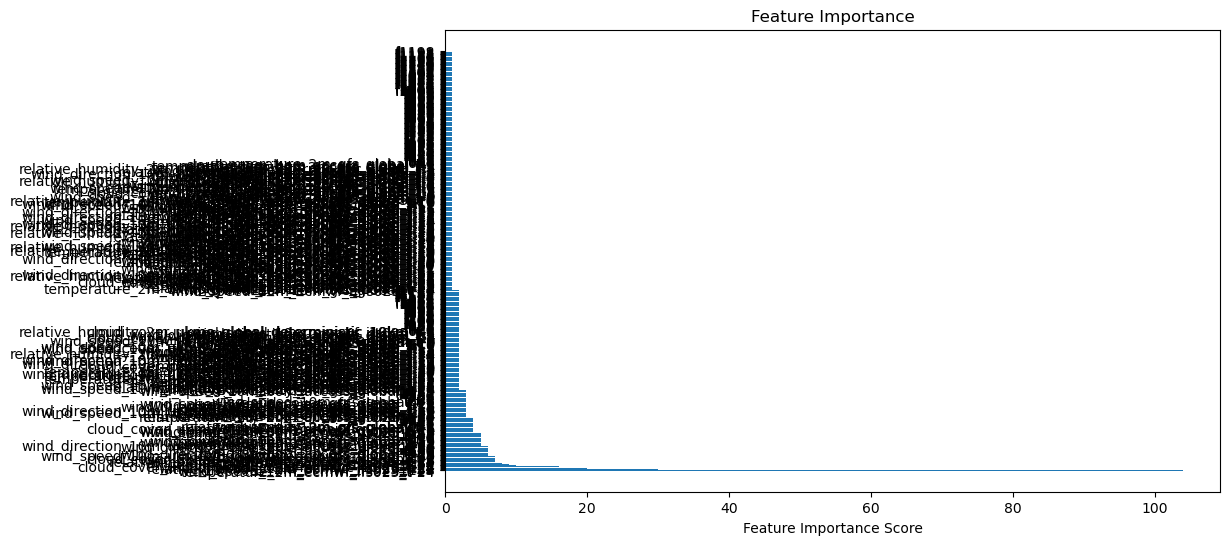

In [85]:
def plot_feature_importance(bst, feature_names):
    # Get feature importance from the trained model
    importance = bst.get_score(importance_type='weight')

    # Sort the feature importance in descending order
    sorted_importance = {k: importance.get(k, 0) for k in sorted(importance, key=importance.get, reverse=True)}

    # Match indices like 'f0', 'f1', ..., with the dynamically generated feature names
    feature_indices = {f'f{i}': feature_names[i] for i in range(len(feature_names))}

    # Remap the sorted feature importance
    sorted_importance_named = {feature_indices.get(k, k): v for k, v in sorted_importance.items()}

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(list(sorted_importance_named.keys()), list(sorted_importance_named.values()))
    plt.xlabel('Feature Importance Score')
    plt.title('Feature Importance')
    plt.show()

# Call the function to plot feature importance
plot_feature_importance(bst, feature_names)

In [89]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to plot predictions, actual values, and input model forecasts
def plot_comparisons(y_test, y_pred, input_features, feature_columns):
    plt.figure(figsize=(12, 8))

    # Plot the actual temperature values
    plt.plot(y_test.index, y_test, label='True Temperature', color='blue', marker='o', linestyle='-', linewidth=2)

    # Plot the XGBoost model's predicted temperature values
    plt.plot(y_test.index, y_pred, label='XGBoost Predicted Temperature', color='red', marker='x', linestyle='--', linewidth=2)

    # Plot the other weather model predictions (input features) for comparison
    for feature in feature_columns:
        plt.plot(y_test.index, input_features[feature], label=f'{feature}', linestyle='-', alpha=0.7)

    # Add titles and labels
    plt.title('Temperature Prediction Comparison')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    
    # Display a legend
    plt.legend(loc='best')

    # Show the plot
    plt.show()

# Example call
# Convert y_test and y_pred to Pandas Series with the same index as `input_features`
y_test = pd.Series(y_test, index=df.index)  # Replace `df.index` with the correct index of your data
y_pred = pd.Series(y_pred, index=df.index)  # Same here, ensure the index matches the test set

# Assume `df` is your test dataframe containing the input weather models' predictions
input_model_columns = ['temperature_2m_ecmwf_ifs025', 'temperature_2m_bom_access_global']  # Add more model columns as needed

# Plot the comparisons
plot_comparisons(y_test, y_pred, df, input_model_columns)

ValueError: Length of values (32) does not match length of index (216)

In [73]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

1.4859434249793773

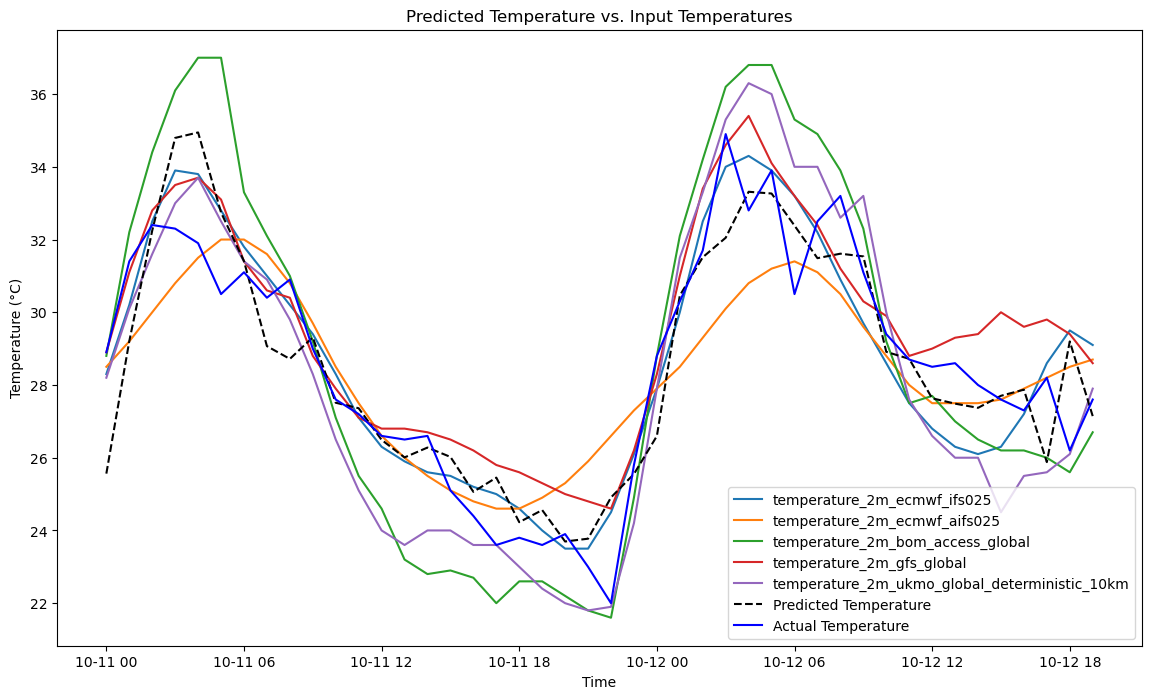

In [74]:
import matplotlib.pyplot as plt

# Plot y_pred against each temperature_2m column from X_test
plt.figure(figsize=(14, 8))

for col in [col for col in X_test.columns if 'temperature_2m' in col]:
    plt.plot(X_test.index, X_test[col], label=col)

plt.plot(X_test.index, y_pred, label='Predicted Temperature', linestyle='--', color='black')

plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Predicted Temperature vs. Input Temperatures')
# Plot actual air_temp
plt.plot(X_test.index, y_test, label='Actual Temperature', linestyle='-', color='blue')

plt.legend()
plt.show()